In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import calendar

In [129]:
#set display format of output from pandas
pd.set_option('display.float_format', lambda x: '%.6f' % x)
#extend chunksize for somes scatter plot
plt.rcParams['agg.path.chunksize'] = 10000

In [228]:
data_types = {
         'Id': np.dtype(int),
         'Store': np.dtype(int),
         'DayOfWeek': 'category',
         #'Date': np.dtype(str), # we will parse it later
         'Sales': np.dtype(int),
         'Customers': np.dtype(int),
         'Open': 'category',
         'Promo': 'category',
         'StateHoliday': np.dtype(str),
         'SchoolHoliday': np.dtype(str)
         }

store_data_types = {
         'Store': np.dtype(int),
         'StoreType': np.dtype(str),
         'Assortment': np.dtype(str),
         'CompetitionDistance': np.dtype('float64'), # to prevent parsing null value
         'CompetitionOpenSinceMonth': np.dtype(str),
         'CompetitionOpenSinceYear': np.dtype(str),
         'Promo2': 'category',
         'Promo2SinceWeek': np.dtype(str),
         'Promo2SinceYear': np.dtype(str),
         'PromoInterval': np.dtype(str)
        }

train = pd.read_csv('input/train.csv', parse_dates=[2], dtype=data_types)
test = pd.read_csv('input/test.csv', parse_dates=[3], dtype=data_types)
store = pd.read_csv('input/store.csv', dtype=store_data_types)

In [ ]:
print('- Train data')
print(train.dtypes)

In [ ]:
print('- Test data')
print(test.dtypes)

In [ ]:
print('- Store data')
print(store.dtypes)

# Data exploration

In [ ]:
train.describe(include='all')

In [ ]:
test.describe(include='all')

In [ ]:
store.describe(include='all')

## Find unique value

In [ ]:
print('- Unique train data without null value')
print(train.nunique())
print('*'*30)
print('- Unique train data with null value')
print(train.nunique(dropna=False))

In [ ]:
# open value has 3 values so we will check it again. (Include null value)
print('- Unique test data without null value')
print(test.nunique())
print('*'*30)
print('- Unique test data with null value')
print(test.nunique(dropna=False))

In [ ]:
# CompetitionDistance, OpenSinceMonth, OpenSinceYear, Promo2, Promo2SinceWeek, Promo2SinceYear, PromoInterval
# contain null value in store data
print('- Unique store data without null value')
print(store.nunique())
print('*'*30)
print('- Unique store data with null value')
print(store.nunique(dropna=False))

In [ ]:
# or just use the following command to summarize null value
print('train data: ', train.columns[train.isnull().any()])
print('test data: ', test.columns[test.isnull().any()])
print('store: ', store.columns[store.isnull().any()])

In [ ]:
# All test stores are in the train data
np.count_nonzero(np.isin(test.Store.unique(), train.Store.unique()))

In [ ]:
# 259 stores in train data are not in test data
train.Store.nunique() - np.count_nonzero(np.isin(test.Store.unique(), train.Store.unique()))

In [ ]:
# The proportion of open and close in train data
objects = ('Open', 'Close')
y = np.arange(len(objects))
x_train = [len(train.Open[train['Open'] == '1'])/len(train.Open), len(train.Open[train['Open'] == '0'])/len(train.Open)]
x_test = [len(test.Open[test['Open'] == '1'])/len(test.Open), len(test.Open[test['Open'] == '0'])/len(test.Open)]

f, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].bar(y, x_train, align='center', alpha=1, color=['aquamarine','tomato'])
ax[0].set_xticks(y)
ax[0].set_xticklabels(list(objects))
ax[0].set_ylabel('Proportion')
ax[0].set_title('train data')

ax[1].bar(y, x_test, align='center', alpha=1, color=['aquamarine','tomato'])
ax[1].set_xticks(y)
ax[1].set_xticklabels(list(objects))
ax[1].set_ylabel('Proportion')
ax[1].set_title('test data')

plt.suptitle('The proportion of the open and close day of shops')
plt.show()

In [ ]:
# no longer use
# The proportion of open and close in train data
objects = ('Open', 'Close')
y = np.arange(len(objects))
x = [len(train.Open[train['Open'] == '1'])/len(train.Open), len(train.Open[train['Open'] == '0'])/len(train.Open)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['aquamarine','tomato'])
plt.xticks(y, objects)
plt.ylabel('Proportion'),
plt.title('The proportion of the open and close day of shops in train data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

In [ ]:
# on test data, the open column contains null value
test.Open[test["Open"].isnull()]

In [ ]:
# no longer use
# The proportion of open and close in test data
objects = ('Open', 'Close')
y = np.arange(len(objects))
x = [len(test.Open[test['Open'] == '1'])/len(test.Open), len(test.Open[test['Open'] == '0'])/len(test.Open)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['aquamarine', 'tomato'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the open and close day of shops in test data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

In [ ]:
# The proportion of promotion and no promotion day in train data 
objects = ('Promotion', 'No Promotion')
y = np.arange(len(objects))
x = [len(train.Promo[train['Promo'] == '1'])/len(train.Promo), len(train.Promo[train['Promo'] == '0'])/len(train.Promo)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['teal','salmon'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the promotion and no promotion day of shops in train data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

In [ ]:
# The proportion of promotion and no promotion day in test data 
objects = ('Promotion', 'No Promotion')
y = np.arange(len(objects))
x = [len(test.Promo[test["Promo"] == '1'])/len(test.Promo), len(test.Promo[test["Promo"] == '0'])/len(test.Promo)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['teal','salmon'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of promotion and no promotion day of shops in test data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

In [ ]:
# The proportion of holiday and normal day in train data 
objects = ('Public Holiday', 'Easter Holiday', 'Christmas', 'None')
y = np.arange(len(objects))
x = [len(train.StateHoliday[train["StateHoliday"] == 'a'])/len(train.StateHoliday), 
               len(train.StateHoliday[train["StateHoliday"] == 'b'])/len(train.StateHoliday), 
               len(train.StateHoliday[train["StateHoliday"] == 'c'])/len(train.StateHoliday), 
               len(train.StateHoliday[train["StateHoliday"] == '0'])/len(train.StateHoliday)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['orange', 'lightblue', 'coral', 'aquamarine'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the state holiday and normal day of shops in train data')
plt.legend([ax[0], ax[1], ax[2], ax[3]], list(objects))
plt.show()

In [ ]:
# The proportion of holiday and normal day in test data 
objects = ('Public Holiday', 'Easter Holiday', 'Christmas', 'None')
y = np.arange(len(objects))
x = [len(test.StateHoliday[test["StateHoliday"] == 'a'])/len(test.StateHoliday), 
               len(test.StateHoliday[test["StateHoliday"] == 'b'])/len(test.StateHoliday), 
               len(test.StateHoliday[test["StateHoliday"] == 'c'])/len(test.StateHoliday), 
               len(test.StateHoliday[test["StateHoliday"] == '0'])/len(test.StateHoliday)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['orange', 'lightblue', 'coral', 'aquamarine'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the state holiday and normal day of shops in test data')
plt.legend([ax[0], ax[1], ax[2], ax[3]], list(objects))
plt.show()

In [ ]:
objects = ('SchoolHoliday', 'None SchoolHoliday')
y = np.arange(len(objects))
x = [len(train.SchoolHoliday[train["SchoolHoliday"] == '1'])/len(train.SchoolHoliday), 
               len(train.SchoolHoliday[train["SchoolHoliday"] == '0'])/len(train.SchoolHoliday)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['coral','aquamarine'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the school holiday of shops in train data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

In [ ]:
objects = ('SchoolHoliday', 'None SchoolHoliday')
y = np.arange(len(objects))
x = [len(test.SchoolHoliday[test["SchoolHoliday"] == '1'])/len(test.SchoolHoliday),
               len(test.SchoolHoliday[test["SchoolHoliday"] == '0'])/len(test.SchoolHoliday)]
 
ax = plt.bar(y, x, align='center', alpha=1, color=['coral','aquamarine'])
plt.xticks(y, objects)
plt.ylabel('Proportion')
plt.title('The proportion of the school holiday of shops in test data')
plt.legend([ax[0], ax[1]], list(objects))
plt.show()

In [ ]:
plt.plot(train.Date.sort_values(ascending=True).reset_index(drop=True), color="indigo")
plt.title('Date value on train data')
plt.xlabel('Index')
plt.show()

In [ ]:
# we have to predict 48 days in test data
plt.plot(test.Date.sort_values(ascending=True).reset_index(drop=True), color="indigo")
plt.title('Date value on test data')
plt.xlabel('Index')
plt.show()

In [ ]:
# histogram of sales in train data
# According to histogram, there are too many zero sales on train data
plt.hist(train.Sales, 100, color="orangered")
plt.xlabel('Sales')
plt.title('Histogram of sales of each store')
plt.show()

In [ ]:
# Show the histogram of mean sales seperated by storeID.
# We have to filter out rows that contain zero sales 
plt.hist(train[train["Sales"] != 0].groupby(['Store']).Sales.mean(),100, color="orangered")
plt.xlabel('Average(Sales)')
plt.title('Histogram of average sales of each store')
plt.show()

In [ ]:
# histogram of customers in train data
# According to histogram, there are zero customers on train data
plt.hist(train.Customers,100, color="teal")
plt.xlabel('Customers')
plt.title('Histogram of customers of each store')
plt.show()

In [ ]:
# Show the histogram of mean customers seperated by storeID.
# We have to filter out rows that contain zero sales 
plt.hist(train[train["Customers"] != 0].groupby(['Store']).Customers.mean(),100, color="teal")
plt.xlabel('Average(Customers)')
plt.title('Histogram of average customers of each store')
plt.show()

## Sales and other features

In [ ]:
# Add boxplot to see a relation between sales and day of week
# May be shops might close on Sunday. 
# So, the density of sales on Sundey is not thick.
bp = train[train["Sales"] != 0].boxplot(column='Sales', by='DayOfWeek', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['yellow','fuchsia', 'teal', 'orangered', 'blue', 'purple', 'tomato']

for i in np.arange(1, 8): # 1-7
    y = train[train["Sales"] != 0].Sales[train.DayOfWeek==str(i)]
    x = np.random.normal(i, 0.1, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.01, color = colors[i-1])
    
plt.xticks(np.arange(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

In [ ]:
# Count the total number of closed shop by day of week.
# It related to density of the above graph.
objects = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
colors=['yellow','fuchsia', 'teal', 'orangered', 'blue', 'purple', 'tomato']

fig, ax = plt.subplots()
for label, df in train[train["Open"] == '0'].groupby('DayOfWeek').DayOfWeek:
    plt.bar(label, df.count(), color=colors[int(label)-1])

plt.xticks(np.arange(1, 8), objects)
plt.show()


In [ ]:
# Add boxplot to see a relation between sales and promotion
bp = train[train["Sales"] != 0].boxplot(column='Sales', by='Promo', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Sales"] != 0].Sales[train.Promo==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.07, color= colors[i])


In [ ]:
# Add boxplot to see a relation between sales and state holiday
bp = train[train["Sales"] != 0].boxplot(column='Sales', by='StateHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors=['aquamarine', 'orange', 'lightblue', 'coral']

for i,j in enumerate(['0', 'a', 'b', 'c']):
    y = train[train["Sales"] != 0].Sales[train.StateHoliday==j]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.5, color= colors[i])

In [ ]:
# Add boxplot to see a relation between sales and school holiday
bp = train[train["Sales"] != 0].boxplot(column='Sales', by='SchoolHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Sales"] != 0].Sales[train.SchoolHoliday==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05, color= colors[i])

## Customers and other features

In [ ]:
# Add boxplot to see a relation between customers and day of week
# May be shops might close on Sunday. 
# So, the density of customers on Sundey is not thick as same as on sales
bp = train[train["Customers"] != 0].boxplot(column='Customers', by='DayOfWeek', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['yellow','fuchsia', 'teal', 'orangered', 'blue', 'purple', 'tomato']

for i in np.arange(1,8): # 1-7
    y = train[train["Customers"] != 0].Customers[train.DayOfWeek==str(i)]
    x = np.random.normal(i, 0.1, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.01, color = colors[i-1])


In [ ]:
# Add boxplot to see a relation between customers and promotion
bp = train[train["Customers"] != 0].boxplot(column='Customers', by='Promo', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Customers"] != 0].Customers[train.Promo==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.01, color= colors[i])


In [ ]:
# Add boxplot to see a relation between customers and state holiday
bp = train[train["Customers"] != 0].boxplot(column='Customers', by='StateHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors=['aquamarine', 'orange', 'lightblue', 'coral']

for i,j in enumerate(['0', 'a', 'b', 'c']):
    y = train[train["Customers"] != 0].Customers[train.StateHoliday==j]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.5, color= colors[i])

In [ ]:
# Add boxplot to see a relation between customers and school holiday
bp = train[train["Customers"] != 0].boxplot(column='Customers', by='SchoolHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Customers"] != 0].Customers[train.SchoolHoliday==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, '.', alpha=0.05, color= colors[i])

In [ ]:
# Sales and Customers with regression line

#import statsmodels.api as sm
#lowess = sm.nonparametric.lowess

sale_and_customer = train[["Sales","Customers"]][(train["Sales"] != 0) & (train["Customers"] != 0)]

x = np.log(sale_and_customer.Customers)
y = np.log(sale_and_customer.Sales)

plt.plot(x, y, '.', color='navy')

filtered = lowess(y, x, is_sorted=False, frac=0.2, it=0)

plt.plot(filtered[:,0], filtered[:,1], 'r')
plt.xlabel('log(Customers)')
plt.ylabel('log(Sales)')
plt.title('Relation between customers and sales')
plt.show()

In [ ]:
# There are just 2 rows that have customers but do not have sales.
train[["Sales","Customers"]][(train["Sales"] == 0) & (train["Customers"] != 0)]

In [ ]:
# Stores that have zero sales in each day
# The stores have different amounts of zero sales
# So, we will explore in the next step
storeWithZeroSales = train[(train["Sales"] == 0)].groupby(['Store']).Sales.size().sort_values(ascending=False)
plt.title('Histogram of zero sales of each store')
plt.hist(storeWithZeroSales,100, color="teal")
plt.xlabel("Store")
plt.show()

In [ ]:
# Store 103 have the most zero sales among all stores
storeWithZeroSales.head()

In [ ]:
# The sales of store 103 
# The first period that new store openning have a high spike on sales
salesByDayStore103 = train[["Sales","Date"]][train["Store"] == 103]
salesByDayStore103WithOpen = train[["Sales","Date"]][(train["Store"] == 103) & (train["Open"] == '1')]

f, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(salesByDayStore103.Date, salesByDayStore103.Sales,'o',markerfacecolor='none', markersize=3, color='lime')
ax[0].set_ylabel('Sales')
ax[0].set_title('Open and closed day')

ax[1].plot(salesByDayStore103WithOpen.Date, salesByDayStore103WithOpen.Sales,'o',
           markerfacecolor='none', markersize=3, color='lime')
ax[1].set_ylabel('Sales')
ax[1].set_title('Only open day')

plt.suptitle('Sales of Store 103')
plt.show()

In [ ]:
# The sales of store 708 
# When stores open after closing for a while, there is a high spike on sales
# It is the same case as closing. When the stores will close for a while, the last day will have a high spike on sales.
salesByDayStore708 = train[["Sales","Date"]][train["Store"] == 708]
salesByDayStore708WithOpen = train[["Sales","Date"]][(train["Store"] == 708) & (train["Open"] == '1')]

f, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(salesByDayStore708.Date, salesByDayStore708.Sales,'ro',markerfacecolor='none', markersize=3, color='lime')
ax[0].set_ylabel('Sales')
ax[0].set_title('Open and closed day')

ax[1].plot(salesByDayStore708WithOpen.Date, salesByDayStore708WithOpen.Sales,'o',
           markerfacecolor='none', markersize=3, color='lime')
ax[1].set_ylabel('Sales')
ax[1].set_title('Only open day')

plt.suptitle('Sales of Store 708')
plt.show()

In [ ]:
# There are some shops that open twentyfour-seven

train[(train["Open"] == '1') & (train["DayOfWeek"] == '7') & (train["StateHoliday"] != '0')].groupby(["Store"]).Store.head()

In [ ]:
# The sales of store 353 
# The sales on Sunday is higher than other days.

# Only sales on Sunday
salesByDayOnSundayStore353 = train[["Sales","Date"]][(train["Store"] == 353) & (train["DayOfWeek"] == '7')]
plt.plot(salesByDayOnSundayStore353.Date, salesByDayOnSundayStore353.Sales, 'r+', alpha=1)

# Sales except Sunday
salesByDayNotSundayStore353 = train[["Sales","Date"]][(train["Store"] == 353) & (train["DayOfWeek"] != '7')]
plt.plot(salesByDayNotSundayStore353.Date, salesByDayNotSundayStore353.Sales, 'bx', alpha=0.5)
plt.ylabel('Sales')
plt.title('Sales on Sunday and other days of store 353')


# Store Data

In [ ]:
store.describe(include='all')

In [ ]:
# Show store type of each store
store.StoreType.value_counts(dropna=False).sort_index()

In [ ]:
# Show Assortment of each store
store.Assortment.value_counts(dropna=False).sort_index()

In [ ]:
# Proo Interval of each store
store.PromoInterval.value_counts(dropna=False).sort_index()

In [ ]:
# Crosstab of assortment and store type
pd.crosstab(store.StoreType,store.Assortment,dropna=False)

In [ ]:
# histogram of distance of competition stores in store data
# According to histogram, some competition stores are far away
plt.hist(store.CompetitionDistance.dropna(), 100, color="orangered")
plt.xlabel('Distance')
plt.title('Histogram of distance of competition stores')
plt.show()

In [ ]:
# Find null value of competition open month and year
monthNullAndYearNotNull = store[["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]][(store["CompetitionOpenSinceMonth"].isnull()) & (~store["CompetitionOpenSinceYear"].isnull())]
monthNotNullAndYearNull = store[["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]][(~store["CompetitionOpenSinceMonth"].isnull()) & (store["CompetitionOpenSinceYear"].isnull())]

print('monthNullAndYearNotNull', len(monthNullAndYearNotNull))
print('monthNotNullAndYearNull', len(monthNotNullAndYearNull))

In [ ]:
# Find null value of competition distance and open year
# There are some stores that have competition distance but do not have open year
distanceNullAndYearNotNull = store[["CompetitionDistance", "CompetitionOpenSinceYear"]][(store["CompetitionDistance"].isnull()) & (~store["CompetitionOpenSinceYear"].isnull())]
distanceNotNullAndYearNull = store[["CompetitionDistance", "CompetitionOpenSinceYear"]][(~store["CompetitionDistance"].isnull()) & (store["CompetitionOpenSinceYear"].isnull())]
print('distanceNullAndYearNotNull', len(distanceNullAndYearNotNull))
print('distanceNotNullAndYearNull', len(distanceNotNullAndYearNull))


In [ ]:
# some of row have distance but doesn't have year and month
# we have to fix it later.
distanceNotNullAndYearNull.head()

In [ ]:
# concat year and month then find the newest competition store date
competitionOpenYearMonth = store.CompetitionOpenSinceYear.str.cat(store.CompetitionOpenSinceMonth)
competitionOpenYearMonth = pd.to_datetime(competitionOpenYearMonth.dropna(), format='%Y%m', errors='ignore').dt.to_period('M')
newestCompetitionYearMonth = competitionOpenYearMonth.sort_values(ascending = False).iloc[0]

In [ ]:
# We have to find how long that each competition store open
# Most stores have open competitions less than 200 days
openSinceInMonth = newestCompetitionYearMonth - competitionOpenYearMonth
openSinceInMonth = openSinceInMonth.astype('int32')
plt.hist(openSinceInMonth,100, color="orangered")
plt.xlabel('Duration')
plt.title('Histogram of duration of opened competition stores')
plt.show()

In [ ]:
# Find null value of promotion week and year
promoWeekNullAndYearNotNull = store[["Promo2SinceWeek", "Promo2SinceYear"]][(store["Promo2SinceWeek"].isnull()) & (~store["Promo2SinceYear"].isnull())]
promoWeekNotNullAndYearNull = store[["Promo2SinceWeek", "Promo2SinceYear"]][(~store["Promo2SinceWeek"].isnull()) & (store["Promo2SinceYear"].isnull())]

print('promoWeekNullAndYearNotNull', len(promoWeekNullAndYearNotNull))
print('promoWeekNotNullAndYearNull', len(promoWeekNotNullAndYearNull))

In [ ]:
# Find null value of promo2 and promo2SinceYear
promoUseAndYearNull = store[["Promo2", "Promo2SinceYear"]][(store["Promo2"] == '1') & (store["Promo2SinceYear"].isnull())]
promoNotUseAndYearNotNull = store[["Promo2", "Promo2SinceYear"]][(store["Promo2"] == '0') & (~store["Promo2SinceYear"].isnull())]
print('promoUseAndYearNull', len(promoUseAndYearNull))
print('promoNotUseAndYearNotNull', len(promoNotUseAndYearNotNull))


In [ ]:
# Find null value of promo2 and PromoInterval
promoUseAndIntervalNull = store[["Promo2", "PromoInterval"]][(store["Promo2"] == '1') & (store["PromoInterval"].isnull())]
promoNotUseAndIntervalNotNull = store[["Promo2", "PromoInterval"]][(store["Promo2"] == '0') & (~store["PromoInterval"].isnull())]
print('promoUseAndIntervalNull', len(promoUseAndIntervalNull))
print('promoNotUseAndIntervalNotNull', len(promoNotUseAndIntervalNotNull))


In [ ]:
# First day of the promotion will start on Monday.
promoStartYearMonth = store[(store["Promo2"] == '1')][['Promo2SinceYear','Promo2SinceWeek']]
promoStartYearMonth = pd.to_datetime(promoStartYearMonth.Promo2SinceWeek.astype(str)+
                          promoStartYearMonth.Promo2SinceYear.astype(str).add('-1') ,format='%W%Y-%w')
newestPromoStartYearMonth = pd.to_datetime(promoStartYearMonth.sort_values(ascending = False).iloc[0])


In [ ]:
# We have to find how long that each store has a promotion
promoSinceInMonth = newestPromoStartYearMonth - promoStartYearMonth
promoSinceInMonth = promoSinceInMonth.astype('timedelta64[D]')
plt.hist(promoSinceInMonth,100, color="orangered")
plt.xlabel('Duration')
plt.title('Histogram of duration of promotion')
plt.show()

In [ ]:
# Sale and Promotion Interval by months
saleAndStore = pd.merge(train, store, on='Store')
saleAndStore.PromoInterval.cat.add_categories('None', inplace=True)
saleAndStore = saleAndStore.fillna({'PromoInterval': 'None'})
bp = saleAndStore[saleAndStore["Sales"] != 0].boxplot(column='Sales', by='PromoInterval', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

PromoInterval=['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', 'None']
colors = ['teal', 'orangered', 'blue', 'purple']

for i,j in enumerate(PromoInterval):
    y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval==j]
    x = np.random.normal(i+1, 0.1, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.4, color= colors[i])

In [ ]:
# Sales by store types
saleDateByStore = saleAndStore[(saleAndStore["Sales"] != 0)][["StoreType","Date","Sales"]]
saleDateByStore = saleDateByStore.groupby(['StoreType','Date']).Sales.mean().reset_index()
saleDateByStoreA = saleDateByStore[saleDateByStore["StoreType"] == 'a'][['Date','Sales']]
saleDateByStoreB = saleDateByStore[saleDateByStore["StoreType"] == 'b'][['Date','Sales']]
saleDateByStoreC = saleDateByStore[saleDateByStore["StoreType"] == 'c'][['Date','Sales']]
saleDateByStoreD = saleDateByStore[saleDateByStore["StoreType"] == 'd'][['Date','Sales']]

filteredA = lowess(saleDateByStoreA.Sales, saleDateByStoreA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(saleDateByStoreB.Sales, saleDateByStoreB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(saleDateByStoreC.Sales, saleDateByStoreC.Date, is_sorted=False, frac=0.2, it=0)
filteredD = lowess(saleDateByStoreD.Sales, saleDateByStoreD.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r', label='StoreA')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g', label='StoreB')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b', label='StoreC')
plt.plot(pd.to_datetime(filteredD[:,0]), filteredD[:,1], 'y', label='StoreD')

plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
# Customers by store types
customerDateByStore = saleAndStore[(saleAndStore["Customers"] != 0)][["StoreType","Date","Customers"]]
customerDateByStore = customerDateByStore.groupby(['StoreType','Date']).Customers.mean().reset_index()
customerDateByStoreA = customerDateByStore[customerDateByStore["StoreType"] == 'a'][['Date','Customers']]
customerDateByStoreB = customerDateByStore[customerDateByStore["StoreType"] == 'b'][['Date','Customers']]
customerDateByStoreC = customerDateByStore[customerDateByStore["StoreType"] == 'c'][['Date','Customers']]
customerDateByStoreD = customerDateByStore[customerDateByStore["StoreType"] == 'd'][['Date','Customers']]

filteredA = lowess(customerDateByStoreA.Customers, customerDateByStoreA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(customerDateByStoreB.Customers, customerDateByStoreB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(customerDateByStoreC.Customers, customerDateByStoreC.Date, is_sorted=False, frac=0.2, it=0)
filteredD = lowess(customerDateByStoreD.Customers, customerDateByStoreD.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r', label='StoreA')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g', label='StoreB')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b', label='StoreC')
plt.plot(pd.to_datetime(filteredD[:,0]), filteredD[:,1], 'y', label='StoreD')

plt.ylabel('Customers')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
# Sales by store types
saleDateByAssortment = saleAndStore[(saleAndStore["Sales"] != 0)][["Assortment","Date","Sales"]]
saleDateByAssortment = saleDateByAssortment.groupby(['Assortment','Date']).Sales.mean().reset_index()
saleDateByAssortmentA = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'a'][['Date','Sales']]
saleDateByAssortmentB = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'b'][['Date','Sales']]
saleDateByAssortmentC = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'c'][['Date','Sales']]

filteredA = lowess(saleDateByAssortmentA.Sales, saleDateByAssortmentA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(saleDateByAssortmentB.Sales, saleDateByAssortmentB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(saleDateByAssortmentC.Sales, saleDateByAssortmentC.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r', label='AssortmentA')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g', label='AssortmentB')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b', label='AssortmentC')

plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
# Customers by store types
customerDateByAssortment = saleAndStore[(saleAndStore["Customers"] != 0)][["Assortment","Date","Customers"]]
customerDateByAssortment = customerDateByAssortment.groupby(['Assortment','Date']).Customers.mean().reset_index()
customerDateByAssortmentA = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'a'][['Date','Customers']]
customerDateByAssortmentB = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'b'][['Date','Customers']]
customerDateByAssortmentC = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'c'][['Date','Customers']]

filteredA = lowess(customerDateByAssortmentA.Customers, customerDateByAssortmentA.Date, is_sorted=False, frac=0.3, it=0)
filteredB = lowess(customerDateByAssortmentB.Customers, customerDateByAssortmentB.Date, is_sorted=False, frac=0.3, it=0)
filteredC = lowess(customerDateByAssortmentC.Customers, customerDateByAssortmentC.Date, is_sorted=False, frac=0.3, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r', label='AssortmentA')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g', label='AssortmentB')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b', label='AssortmentC')

plt.ylabel('Customers')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
# Sales and distance
sale_and_distance = saleAndStore[["Sales","CompetitionDistance"]][(saleAndStore["Sales"] != 0) & (~saleAndStore["CompetitionDistance"].isnull())].groupby(['CompetitionDistance']).Sales.mean().reset_index()

x = np.log(sale_and_distance.CompetitionDistance)
y = np.log(sale_and_distance.Sales)

plt.plot(x, y, '.b')

filtered = lowess(y, x, is_sorted=False, frac=0.3, it=0)

plt.plot(filtered[:,0], filtered[:,1], 'r')

plt.xlabel('log(CompetitionDistance)')
plt.ylabel('log(Sales)')
plt.title('Relation between competition distance and sales')
plt.show()

In [ ]:
# Customers and distance
customer_and_distance = saleAndStore[["Customers","CompetitionDistance"]][(saleAndStore["Customers"] != 0) & (~saleAndStore["CompetitionDistance"].isnull())].groupby(['CompetitionDistance']).Customers.mean().reset_index()

x = np.log(customer_and_distance.CompetitionDistance)
y = np.log(customer_and_distance.Customers)

plt.plot(x, y, '.b')

filtered = lowess(y, x, is_sorted=False, frac=0.3, it=0)

plt.plot(filtered[:,0], filtered[:,1], 'r')

plt.xlabel('log(CompetitionDistance)')
plt.ylabel('log(Customers)')
plt.title('Relation between competition distance and customers')
plt.show()

In [ ]:
# If stores have competitions, sales might slightly decrease
SalesAndCompetition = saleAndStore[['Sales','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
SalesAndCompetition = SalesAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
SalesAndCompetition['isCompetition'] = np.where((SalesAndCompetition.Date.dt.year >= SalesAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (SalesAndCompetition.Date.dt.month >= SalesAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')

bp = SalesAndCompetition[SalesAndCompetition["Sales"] != 0].boxplot(column='Sales', by='isCompetition', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = SalesAndCompetition[SalesAndCompetition["Sales"] != 0].Sales[SalesAndCompetition.isCompetition==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.02, color= colors[i])


In [ ]:
# If stores have competitions, customers might slightly decrease
CustomersAndCompetition = saleAndStore[['Customers','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
CustomersAndCompetition = CustomersAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
CustomersAndCompetition['isCompetition'] = np.where((CustomersAndCompetition.Date.dt.year >= CustomersAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (CustomersAndCompetition.Date.dt.month >= CustomersAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')

bp = CustomersAndCompetition[CustomersAndCompetition["Customers"] != 0].boxplot(column='Customers', by='isCompetition', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = CustomersAndCompetition[CustomersAndCompetition["Customers"] != 0].Customers[CustomersAndCompetition.isCompetition==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.02, color= colors[i])


In [ ]:
saleAndCompetitionBeforeAfter = saleAndStore[~saleAndStore['CompetitionOpenSinceYear'].isnull()][['Store','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Sales']]

competitionOpenYearMonth = saleAndCompetitionBeforeAfter.CompetitionOpenSinceYear.str.cat(saleAndCompetitionBeforeAfter.CompetitionOpenSinceMonth)
saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] = pd.to_datetime(competitionOpenYearMonth.dropna(), format='%Y%m', errors='ignore')
saleAndCompetitionBeforeAfter['competitionOpenYearMonthBefore'] = saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=-5)
saleAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'] = saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=5)

result = saleAndCompetitionBeforeAfter[['Store', 'Date', 'Sales','competitionOpenYearMonth']][((saleAndCompetitionBeforeAfter['Date'] >= saleAndCompetitionBeforeAfter['competitionOpenYearMonthBefore']) & (saleAndCompetitionBeforeAfter['Date'] <= saleAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'])) & (saleAndCompetitionBeforeAfter['Sales']!=0)]

filtered = lowess(result.Sales, (result.Date - result.competitionOpenYearMonth).dt.days, is_sorted=False, frac=0.5, it=0)

plt.plot(filtered[:,0], filtered[:,1], '.g')

plt.xlabel('Days')
plt.ylabel('Sales')
plt.title('Sales before and after competition store open')
plt.show()



In [ ]:
customersAndCompetitionBeforeAfter = saleAndStore[~saleAndStore['CompetitionOpenSinceYear'].isnull()][['Store','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Customers']]

competitionOpenYearMonth = customersAndCompetitionBeforeAfter.CompetitionOpenSinceYear.str.cat(customersAndCompetitionBeforeAfter.CompetitionOpenSinceMonth)
customersAndCompetitionBeforeAfter['competitionOpenYearMonth'] = pd.to_datetime(competitionOpenYearMonth.dropna(), format='%Y%m', errors='ignore')
customersAndCompetitionBeforeAfter['competitionOpenYearMonthBefore'] = customersAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=-5)
customersAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'] = customersAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=5)

result = customersAndCompetitionBeforeAfter[['Store', 'Date', 'Customers','competitionOpenYearMonth']][((customersAndCompetitionBeforeAfter['Date'] >= customersAndCompetitionBeforeAfter['competitionOpenYearMonthBefore']) & (customersAndCompetitionBeforeAfter['Date'] <= customersAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'])) & (customersAndCompetitionBeforeAfter['Customers']!=0)]

filtered = lowess(result.Customers, (result.Date - result.competitionOpenYearMonth).dt.days, is_sorted=False, frac=0.5, it=0)

plt.plot(filtered[:,0], filtered[:,1], '.g')

plt.xlabel('Days')
plt.ylabel('Customers')
plt.title('Customers before and after competition store open')
plt.show()


In [ ]:
saleAndDate = saleAndStore[['Sales','Date']][saleAndStore['Sales'] != 0]
saleByMonth2013 = saleAndDate[saleAndDate['Date'].dt.year == 2013].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2014 = saleAndDate[saleAndDate['Date'].dt.year == 2014].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2015 = saleAndDate[saleAndDate['Date'].dt.year == 2015].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)

plt.plot(saleByMonth2013.keys(), (saleByMonth2013 / np.mean(saleByMonth2013)) * 100, '-g', label = '2013')
plt.plot(saleByMonth2014.keys(), (saleByMonth2014 / np.mean(saleByMonth2014)) * 100, '-r', label = '2014')
plt.plot(saleByMonth2015.keys(), (saleByMonth2015 / np.mean(saleByMonth2015)) * 100, '-b', label = '2015')

plt.xlabel('Month')
plt.ylabel('Percent sales')
plt.title('Sales by months')
plt.legend()
plt.show()


In [ ]:
customerAndDate = saleAndStore[['Customers','Date']][saleAndStore['Customers'] != 0]
customerByMonth2013 = customerAndDate[customerAndDate['Date'].dt.year == 2013].groupby(customerAndDate['Date'].dt.strftime('%m'))['Customers'].mean().sort_index(level="Date", ascending=True)
customerByMonth2014 = customerAndDate[customerAndDate['Date'].dt.year == 2014].groupby(customerAndDate['Date'].dt.strftime('%m'))['Customers'].mean().sort_index(level="Date", ascending=True)
customerByMonth2015 = customerAndDate[customerAndDate['Date'].dt.year == 2015].groupby(customerAndDate['Date'].dt.strftime('%m'))['Customers'].mean().sort_index(level="Date", ascending=True)

plt.plot(customerByMonth2013.keys(), (customerByMonth2013 / np.mean(customerByMonth2013)) * 100, '-g', label = '2013')
plt.plot(customerByMonth2014.keys(), (customerByMonth2014 / np.mean(customerByMonth2014)) * 100, '-r', label = '2014')
plt.plot(customerByMonth2015.keys(), (customerByMonth2015 / np.mean(customerByMonth2015)) * 100, '-b', label = '2015')

plt.xlabel('Month')
plt.ylabel('Percent customers')
plt.title('Customers by months')
plt.legend()
plt.show()


In [ ]:
# Sale and Promotion Interval by months
saleAndStore = pd.merge(train, store, on='Store')
saleAndStore.PromoInterval.cat.add_categories('None', inplace=True)
saleAndStore = saleAndStore.fillna({'PromoInterval': 'None'})
bp = saleAndStore[saleAndStore["Sales"] != 0].boxplot(column='Sales', by='PromoInterval', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

PromoInterval=['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', 'None']
colors = ['teal', 'orangered', 'blue', 'purple']

for i,j in enumerate(PromoInterval):
    y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval==j]
    x = np.random.normal(i+1, 0.1, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.4, color= colors[i])

In [ ]:
# If stores have competitions, sales might slightly decrease
SalesAndCompetition = saleAndStore[['Sales','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
SalesAndCompetition = SalesAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
SalesAndCompetition['isCompetition'] = np.where((SalesAndCompetition.Date.dt.year >= SalesAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (SalesAndCompetition.Date.dt.month >= SalesAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')

bp = SalesAndCompetition[SalesAndCompetition["Sales"] != 0].boxplot(column='Sales', by='isCompetition', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = SalesAndCompetition[SalesAndCompetition["Sales"] != 0].Sales[SalesAndCompetition.isCompetition==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.02, color= colors[i])


# Feature selection

In [131]:
# get only rows that the shops are open
train[train["Open"] == '0'].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1


In [132]:
# train data
# remove the row that shops are closed
train = train[train["Open"] != '0']

In [133]:
# Merge with store data
train = pd.merge(train, store, on='Store')

In [134]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.000000,9,2008,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.000000,9,2008,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.000000,9,2008,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.000000,9,2008,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.000000,9,2008,0,NaN,NaN,NaN


In [135]:
# Add is Competition
SalesAndCompetition = train[['Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
SalesAndCompetition = SalesAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
train['isCompetition'] = np.where((SalesAndCompetition.Date.dt.year >= SalesAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (SalesAndCompetition.Date.dt.month >= SalesAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')


In [136]:
# Add is Promo2
SalesAndPromo2 = train[['Date','Promo2','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']]
SalesAndPromo2 = SalesAndPromo2.fillna({'Promo2SinceYear': '9999', 'Promo2SinceWeek': '99', 'PromoInterval': 'None'})
train['isPromo2'] = np.where((SalesAndPromo2.Date.dt.year >= SalesAndPromo2['Promo2SinceYear'].astype(int)) &
                             (SalesAndPromo2.Date.dt.week >= SalesAndPromo2['Promo2SinceWeek'].astype(int))
                             , '1', '0')
train['isPromo2'] = train.apply(lambda x: '1' if x.isPromo2 != '0' and calendar.month_abbr[x.Date.month] in x.PromoInterval else '0', axis=1)



In [137]:
train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Day'] = train.Date.dt.day
train['WeekOfYear'] = train.Date.dt.weekofyear

In [138]:
train.loc[train['StateHoliday'] == 'a', 'StateHoliday'] = '1'
train.loc[train['StateHoliday'] == 'b', 'StateHoliday'] = '2'
train.loc[train['StateHoliday'] == 'c', 'StateHoliday'] = '3'
train['StateHoliday'] = train['StateHoliday'].astype(float)

In [139]:
train.loc[train['StoreType'] == 'a', 'StoreType'] = '1'
train.loc[train['StoreType'] == 'b', 'StoreType'] = '2'
train.loc[train['StoreType'] == 'c', 'StoreType'] = '3'
train.loc[train['StoreType'] == 'd', 'StoreType'] = '4'
train['StoreType'] = train['StoreType'].astype(float)

In [140]:
train.loc[train['Assortment'] == 'a', 'Assortment'] = '1'
train.loc[train['Assortment'] == 'b', 'Assortment'] = '2'
train.loc[train['Assortment'] == 'c', 'Assortment'] = '3'
train['Assortment'] = train['Assortment'].astype(float)

In [141]:
train.CompetitionDistance.fillna(1, inplace=True)

In [142]:
train_data = train[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'isCompetition', 'isPromo2', 'Year', 'Month', 'Day', 'WeekOfYear']]
train_target = train[['Sales']]

In [144]:
train_data.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,isCompetition,isPromo2,Year,Month,Day,WeekOfYear
0,1,5,1,0.000000,1,3.000000,1.000000,1270.000000,0,0,2015,7,31,31
1,1,4,1,0.000000,1,3.000000,1.000000,1270.000000,0,0,2015,7,30,31
2,1,3,1,0.000000,1,3.000000,1.000000,1270.000000,0,0,2015,7,29,31
3,1,2,1,0.000000,1,3.000000,1.000000,1270.000000,0,0,2015,7,28,31
4,1,1,1,0.000000,1,3.000000,1.000000,1270.000000,0,0,2015,7,27,31


In [93]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Feature ranking:
1. feature Store (0.146940)
2. feature Day (0.145759)
3. feature CompetitionDistance (0.143869)
4. feature WeekOfYear (0.113133)
5. feature DayOfWeek (0.085064)
6. feature Year (0.073011)
7. feature Month (0.072006)
8. feature StoreType (0.044681)
9. feature isCompetition (0.044027)
10. feature SchoolHoliday (0.035385)
11. feature isPromo2 (0.033615)
12. feature Assortment (0.032958)
13. feature Promo (0.019098)
14. feature StateHoliday (0.010455)


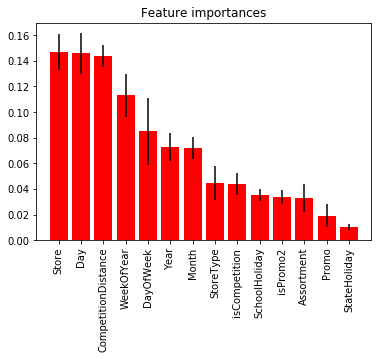

In [157]:
from sklearn.ensemble import RandomForestClassifier

# Build a classification task using 3 informative features

# Build a forest and compute the feature importances
forest = RandomForestClassifier(max_depth=10, random_state=0)


X = train_data
y = train_target
forest.fit(X, y.values.ravel())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), list(map(lambda x: X.columns[x], indices)), rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Feature ranking:
1. feature Store (0.117028)
2. feature CompetitionDistance (0.109079)
3. feature Day (0.098419)
4. feature WeekOfYear (0.093262)
5. feature DayOfWeek (0.089786)
6. feature Month (0.085611)
7. feature Year (0.079133)
8. feature StoreType (0.079132)
9. feature Assortment (0.056629)
10. feature SchoolHoliday (0.052768)
11. feature isCompetition (0.045696)
12. feature Promo (0.040441)
13. feature isPromo2 (0.035587)
14. feature StateHoliday (0.017430)


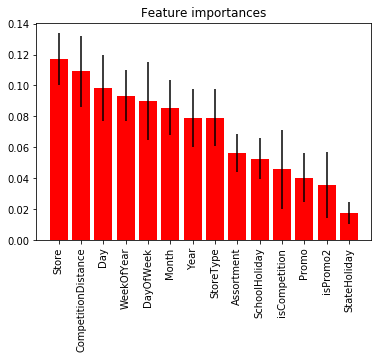

In [158]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(max_depth=10,
                              n_estimators=5,
                              random_state=0)


X = train_data
y = train_target
forest.fit(X, y.values.ravel())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), list(map(lambda x: X.columns[x], indices)), rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [80]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,isCompetition,isPromo2,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0.000000,1,3.000000,...,0,NaN,NaN,NaN,0,0,2015,7,31,31
1,1,4,2015-07-30,5020,546,1,1,0.000000,1,3.000000,...,0,NaN,NaN,NaN,0,0,2015,7,30,31
2,1,3,2015-07-29,4782,523,1,1,0.000000,1,3.000000,...,0,NaN,NaN,NaN,0,0,2015,7,29,31
3,1,2,2015-07-28,5011,560,1,1,0.000000,1,3.000000,...,0,NaN,NaN,NaN,0,0,2015,7,28,31
4,1,1,2015-07-27,6102,612,1,1,0.000000,1,3.000000,...,0,NaN,NaN,NaN,0,0,2015,7,27,31


In [159]:
train_data = train[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'isCompetition', 'isPromo2', 'Year', 'Month', 'Day', 'WeekOfYear']]
train_target = train[['Sales']]
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=0)

# Prediction

In [160]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [161]:
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

In [162]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

## Polynomial 3 degree

In [163]:
polynomial_features = PolynomialFeatures(degree=3,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

In [119]:
rmspe(y_test.values.ravel(), y_pred)

0.37299802033068236

## Extra Tree Regressor

In [164]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor

forest = ExtraTreesRegressor(n_jobs = -1, n_estimators = 10)

forest.fit(X_train, y_train.values.ravel())

y_pred = forest.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.19366753742544612

## Random Forest Regressor

In [165]:
from sklearn.ensemble import RandomForestRegressor

# Fit random forest model
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 10)
rf.fit(X_train, y_train.values.ravel())
print('model fit')

# Make predictions
y_pred = rf.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

model fit


0.13918777806213883

## Ada Boost Regressor

In [166]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Fit random forest model
rf = AdaBoostRegressor(DecisionTreeRegressor(),
                          n_estimators=50)
rf.fit(X_train, y_train.values.ravel())
print('model fit')

# Make predictions
y_pred = rf.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

model fit


0.13809381202844637

In [175]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1,1,0,0,c,a,1270.000000,9,2008,0,NaN,NaN,NaN
1,857,1,3,2015-09-16,1,1,0,0,c,a,1270.000000,9,2008,0,NaN,NaN,NaN
2,1713,1,2,2015-09-15,1,1,0,0,c,a,1270.000000,9,2008,0,NaN,NaN,NaN
3,2569,1,1,2015-09-14,1,1,0,0,c,a,1270.000000,9,2008,0,NaN,NaN,NaN
4,3425,1,7,2015-09-13,0,0,0,0,c,a,1270.000000,9,2008,0,NaN,NaN,NaN


# Predict Unseen Data

In [229]:
test = pd.merge(test, store, on='Store')
test.loc[test.Open.isnull(), 'Open'] = '1'

In [176]:
# Add is Competition
SalesAndCompetition = test[['Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
SalesAndCompetition = SalesAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
test['isCompetition'] = np.where((SalesAndCompetition.Date.dt.year >= SalesAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (SalesAndCompetition.Date.dt.month >= SalesAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')


In [177]:
# Add is Promo2
SalesAndPromo2 = test[['Date','Promo2','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']]
SalesAndPromo2 = SalesAndPromo2.fillna({'Promo2SinceYear': '9999', 'Promo2SinceWeek': '99', 'PromoInterval': 'None'})
test['isPromo2'] = np.where((SalesAndPromo2.Date.dt.year >= SalesAndPromo2['Promo2SinceYear'].astype(int)) &
                             (SalesAndPromo2.Date.dt.week >= SalesAndPromo2['Promo2SinceWeek'].astype(int))
                             , '1', '0')
test['isPromo2'] = test.apply(lambda x: '1' if x.isPromo2 != '0' and calendar.month_abbr[x.Date.month] in x.PromoInterval else '0', axis=1)



In [178]:
test['Year'] = test.Date.dt.year
test['Month'] = test.Date.dt.month
test['Day'] = test.Date.dt.day
test['WeekOfYear'] = test.Date.dt.weekofyear

In [179]:
test.loc[test['StateHoliday'] == 'a', 'StateHoliday'] = '1'
test.loc[test['StateHoliday'] == 'b', 'StateHoliday'] = '2'
test.loc[test['StateHoliday'] == 'c', 'StateHoliday'] = '3'
test['StateHoliday'] = test['StateHoliday'].astype(float)

In [180]:
test.loc[test['StoreType'] == 'a', 'StoreType'] = '1'
test.loc[test['StoreType'] == 'b', 'StoreType'] = '2'
test.loc[test['StoreType'] == 'c', 'StoreType'] = '3'
test.loc[test['StoreType'] == 'd', 'StoreType'] = '4'
test['StoreType'] = test['StoreType'].astype(float)

In [181]:
test.loc[test['Assortment'] == 'a', 'Assortment'] = '1'
test.loc[test['Assortment'] == 'b', 'Assortment'] = '2'
test.loc[test['Assortment'] == 'c', 'Assortment'] = '3'
test['Assortment'] = test['Assortment'].astype(float)

In [182]:
test.CompetitionDistance.fillna(1, inplace=True)

In [183]:
test_data = test[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'isCompetition', 'isPromo2', 'Year', 'Month', 'Day', 'WeekOfYear']]

In [184]:
test_data.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,isCompetition,isPromo2,Year,Month,Day,WeekOfYear
0,1,4,1,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,17,38
1,1,3,1,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,16,38
2,1,2,1,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,15,38
3,1,1,1,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,14,38
4,1,7,0,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,13,37


In [185]:
test_y_pred = rf.predict(test_data)


In [230]:
test['Sales'] = test_y_pred

In [193]:
test_data.head(14)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,isCompetition,isPromo2,Year,Month,Day,WeekOfYear,Sales
0,1,4,1,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,17,38,4383.000000
1,1,3,1,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,16,38,4427.000000
2,1,2,1,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,15,38,4806.000000
3,1,1,1,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,14,38,5402.000000
4,1,7,0,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,13,37,13183.000000
5,1,6,0,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,12,37,4270.000000
6,1,5,0,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,11,37,3808.000000
7,1,4,0,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,10,37,3518.000000
8,1,3,0,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,9,37,3558.000000
9,1,2,0,0.000000,0,3.000000,1.000000,1270.000000,1,0,2015,9,8,37,3650.000000


In [247]:
len(test[['Date','Sales']][test['Store'] == 3])

48

In [248]:
sales_store1 = train[['Date','Sales']][(train['Store'] == 3) & (train['Open'] == '1')]
sales_store1_predict = test[['Date','Sales']][test['Store'] == 3]

In [218]:
test = pd.concat([sales_store1, sales_store1_predict])

In [239]:
sales_store1_predict.head()

,Date,Sales


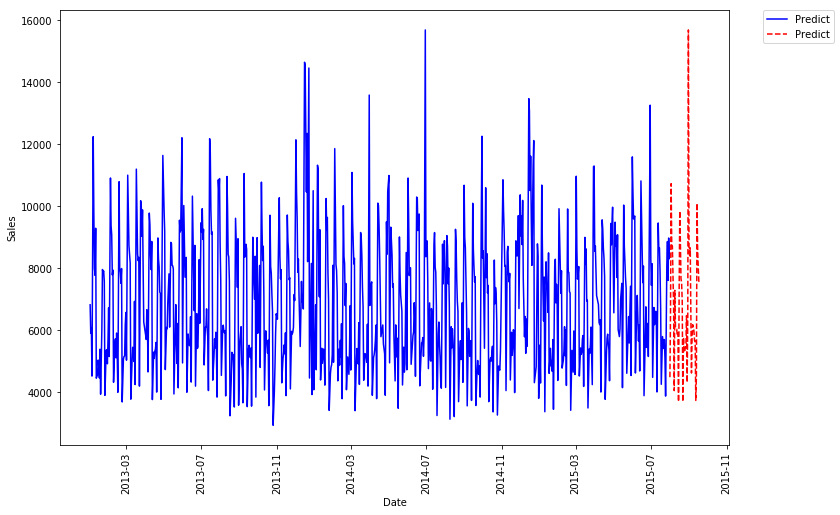

In [249]:

#filtered_store_1 = lowess(test.Sales, test.Date, is_sorted=False, frac=0.2, it=0)
#filtered_store_1_predict = lowess(sales_store1_predict.Sales, sales_store1_predict.Date, is_sorted=False, frac=0.2, it=0)

#plt.plot(pd.to_datetime(filtered_store_1[:,0]), filtered_store_1[:,1], '-r', label='Actual')

#plt.plot(pd.to_datetime(filtered_store_1_predict[:,0]), filtered_store_1_predict[:,1], '--b', label='Predict')
plt.figure(figsize=(12, 8))
plt.plot(pd.to_datetime(sales_store1.Date), sales_store1.Sales, '-b', label='Predict')
plt.plot(pd.to_datetime(sales_store1_predict.Date), sales_store1_predict.Sales, '--r', label='Predict')

plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)
plt.show()